In [89]:
import cv2 as cv2
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline
import math

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [13]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "200128_dark/coco.names" #classes txt file
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "200128_dark/yolov3.cfg"
modelWeights = "../../../../yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [14]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()] #layer 번호는 1부터 시작

In [20]:
l = net.getLayerNames()
print(len(l))
print(l)

print(net.getUnconnectedOutLayers()) #output layers' index return

print('yolo layer로 정의된 세 개', l[199])
print(l[226])
print(l[253])

254
['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38',

In [16]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #레이블 위치 계산
    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]   #행
    frameWidth = frame.shape[1]    #열

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId] #n번 클래스의 사람일 확률
            if confidence > confThreshold:  #옆의 cell 또한 같은 class일 확률이 높음.
                center_x = int(detection[0] * frameWidth)  #detection은 0~1 normalized values
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # Lower confidences.
    #같은 객체면 합치기. 거리, class id
    print(len(boxes))  #확률값이 0.5 이상인 박스 후보자들.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    print(indices) #11개.
    
    for i in indices:
        i = i[0]        #그냥 indices의 return이 2차원 벡터라서.
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [17]:
cap = cv2.VideoCapture('200128_dark/dog.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], True, crop=False)
#test data라고 보면 됨. 를 흘려줘야.
#무조건 float type. 영상뿐만 아니라 보편적인 input을 처리해야 하므로.
#numpy type
#영상은 보통 4차원(개수,폭,높이,채널수). 출력하면 순서가 바뀌어있어 (1,3,416,416)
#darknet 데이터는 내부에서 이미 0~1로 내부적으로 normalized -> scale factor=/255
#[0,0,0]: 평균 이동 factor
net.setInput(blob) #꼭 영상만 처리하는 게 아님. 1,2차원도 input 가능.

outs = net.forward(getOutputsNames(net))

In [9]:
print(type(outs))
print(len(outs))

print(outs[0].shape) #prediction 결과. bounding box의 값. #507=13*13*3
print(outs[1].shape) #두번째 박스는 2028개의 box 있는 것.
print(outs[2].shape) #85 = classes 80 + 5 parameters

print(outs[0][0]) # yolo Layer 1  0번째 box
#첫번째 셀, 첫번째 출력에서의 bounding box의 정보
#크기는 0~1로 normalized value

<class 'list'>
3
(507, 85)
(2028, 85)
(8112, 85)
[3.5737373e-02 4.2604551e-02 3.9501688e-01 1.3538493e-01 4.4566519e-08
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00

In [87]:
print(blob.shape)

(1, 3, 416, 416)


In [10]:
detection=outs[0][0] #85 data
scores = detection[5:]
print(scores) #80 classes에 해당하는 개체의 확률
classId = np.argmax(scores)
print(classId)
confidence = scores[classId]\


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
0


In [19]:
postprocess(frame, outs)

3
[[2]
 [1]
 [0]]


In [18]:
postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

3
[[2]
 [1]
 [0]]


array([[[ 50,  58,  56],
        [ 51,  59,  57],
        [ 53,  61,  59],
        ...,
        [ 31, 102, 119],
        [ 39,  53,  77],
        [ 45,  59,  83]],

       [[ 51,  59,  57],
        [ 51,  59,  57],
        [ 52,  60,  58],
        ...,
        [ 21,  86, 104],
        [ 41,  54,  73],
        [ 46,  59,  78]],

       [[ 51,  59,  56],
        [ 51,  59,  56],
        [ 52,  60,  57],
        ...,
        [ 10,  64,  83],
        [ 47,  58,  67],
        [ 42,  53,  62]],

       ...,

       [[179, 167, 160],
        [179, 167, 160],
        [183, 170, 163],
        ...,
        [ 64,  63,  80],
        [ 36,  39,  52],
        [ 48,  51,  64]],

       [[181, 170, 161],
        [180, 169, 160],
        [176, 165, 156],
        ...,
        [ 61,  61,  77],
        [ 37,  41,  54],
        [ 52,  56,  69]],

       [[177, 166, 157],
        [178, 167, 158],
        [173, 162, 153],
        ...,
        [ 62,  62,  78],
        [ 33,  37,  50],
        [ 35,  39,  52]]

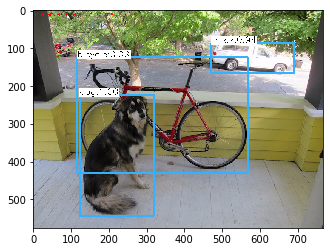

In [12]:
cv2.imwrite("200128_dark/out.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

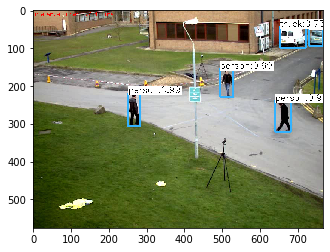

In [13]:
cap = cv2.VideoCapture('img/people2.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

cv2.imwrite("200128_dark/out2.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

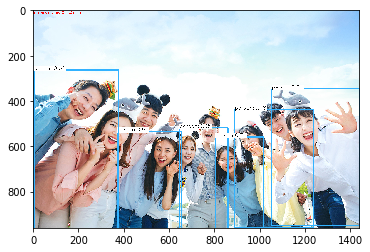

In [14]:
cap = cv2.VideoCapture('img/main_slide01.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

cv2.imwrite("200128_dark/out3.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

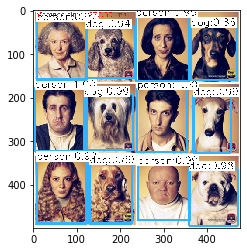

In [11]:
cap = cv2.VideoCapture('img/dog.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

cv2.imwrite("200128_dark/out4.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

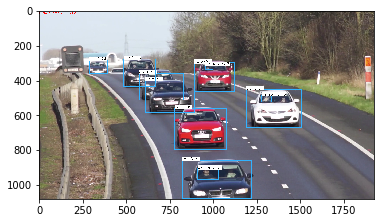

In [10]:
cap = cv2.VideoCapture('img/cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

cv2.imwrite("200128_dark/out5.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)
#object 11개 나오네

## 중간점검
첫번째 박스의 검출 output을 출력  

yolo_82 layer (첫번째 output layer) 크기가 507x85 = 13 * 13 * 3 * (5+80)  
이 행렬의 의미를 파악하기 위해서  
507개의 박스정보 중에서 confidence probability>0.5 인 박스만 다 그려  
-> 최소한 이 level에서 검출할 수 있는 object  
결과: 원래 이미지의 507개 박스 중에서 어떤 건지. rectangle 그려봐  

In [23]:
net.forward('yolo_82').shape

(507, 85)

In [28]:
net.forward('yolo_82')[5:].shape

(502, 85)

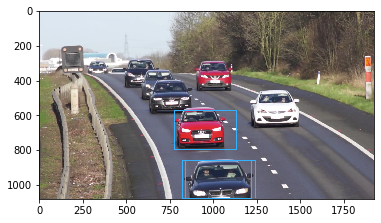

In [93]:
cap = cv2.VideoCapture('img/cars.jpg')

hasFrame, frame = cap.read()

blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)




frameHeight = frame.shape[0]
frameWidth = frame.shape[1]

classIds = []
confidences = []
boxes = []

yolo = net.forward('yolo_82') #82:첫번째 output layer 106: 3rd
for detection in yolo:
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:    #0.5로하면 1개 box 나옴
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        classIds.append(classId)
        confidences.append(float(confidence))
        boxes.append([left, top, width, height])


for i in range(len(boxes)):
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (left + width, top + height), (255, 178, 50), 3)


img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [35]:
boxes

[[824, 856, 396, 222]]

In [36]:
boxes[0]

[824, 856, 396, 222]

In [37]:
boxes[0][0]

824

In [39]:
len(boxes)

1

### 셀 표시하기
cell마다 할당된 id 값. 각 셀이 어느 위치에 해당되는지.  
0은 배경 (정보가 없는) 검정색.  

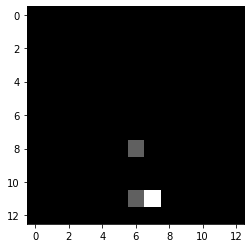

In [133]:
cells = []
for i in range(len(yolo))     :   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    
    confidence = scores[classId]
    if confidence > 0.01:
        cells.append(classId+1) #숫자 늘릴수록 밝아지는(?)
    else :
        cells.append(0)


#np.random.randint(5, size=(80, 34))

cells = np.array(cells)
s = int(math.sqrt(len(yolo)/3))
cells = cells.reshape(s,s,3)

img = cells[:,:,0]*70
imshow("", img)

In [59]:
out.shape

(507, 85)

In [60]:
len(out)

507

In [62]:
out[0].shape

(85,)

In [106]:
out[451]

array([5.7636076e-01, 8.7172973e-01, 4.3531576e-01, 2.9036629e-01,
       1.7010760e-05, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [104]:
out[451][5:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [105]:
np.argmax(out[451][5:])

0

## Snowman

In [127]:
#동영상 file writing

fourcc = cv2.VideoWriter_fourcc(*'mpv4') #코덱
#fourcc = cv2.VideoWriter_fourcc('m','p','v','4') 를 간단히 표현한 게 위
out = cv2.VideoWriter("out.mp4", fourcc, 1.0, (640,480))
# 1 fps

img1 = cv2.imread('img/book1.jpg')
out.write(img1)
img1 = cv2.imread('img/book2.jpg')
out.write(img1)
img1 = cv2.imread('img/book3.jpg')
out.write(img1)
img1 = cv2.imread('img/book4.jpg')
out.write(img1)

out.release()

In [123]:
#함수 호출 방법 중 하나
#호출 과정에서 *의 의미: 원소 하나하나를 mapping하여 넣어줌

def fun(a,b,c) :
    print(a)
    print(b)
    print(c)
fun(1,2,3)
fun(*[1,2,3])
fun(*"가나다")

1
2
3
1
2
3
가
나
다


In [138]:
import cv2
import time
img = cv2.imread('img/book1.jpg')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter("vtest_out.avi", fourcc, 20.0, (img.shape[1], img.shape[0]))

cap = cv2.VideoCapture("vtest.avi")

for i in range(100) :
    ret, frame = cap.read()
    
#    // yolo
    
    video.write(img)
    #time.sleep(0.01

video.release()

In [ ]:
import time
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter("vtest_out.avi", fourcc, 20.0, (576, 768))

cap = cv2.VideoCapture('vtest.avi')

for i in range(50) :
    ret, frame = cap.read()         
    blob = cv2.dnn.blobFromImage(frame, 1/255,
            (inpWidth, inpHeight), [0,0,0], True, crop=False)    
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net))    
    postprocess(frame, outs)
    video.write(frame)    
    time.sleep(0.05)
video.release()

re

In [143]:
import cv2 as cv2
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
print(fourcc)
out = cv2.VideoWriter("output.avi", fourcc, 10, (513,400))
for i in range(60) :
    img1 = cv2.imread('img/book1.jpg')
    out.write(img1)    
out.release()

1482049860


In [144]:
img1.shape

(513, 400, 3)

In [145]:
import time
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter("out.mp4", fourcc, 20.0, (576, 768))

cap = cv2.VideoCapture('vtest.avi')

for i in range(50) :
    ret, frame = cap.read()         
    blob = cv2.dnn.blobFromImage(frame, 1/255,
            (inpWidth, inpHeight), [0,0,0], True, crop=False)    
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net))    
    postprocess(frame, outs)    
    video.write(frame)    
    cv2.waitKey(20)
video.release()

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [141]:
cap = cv2.VideoCapture('vtest.avi')
ret, frame = cap.read()      
frame.shape

AttributeError: 'NoneType' object has no attribute 'shape'